# Analyzing similarity of molecular dataset

This notebook illustrates how the `NearestNeighborsRetrieverTanimoto` can be used for analyzing the Tanimoto similarities of two datasets. 

Such analysis can be useful for many applications. For example, for analyzing how similar new molecules are to the training set to assess the applicability domain when making predictions. Alternatively the similarity of training and test set can be evaluated to understand how well the model generalizes. 

The notebook has the following sections:

**How to compute dataset similarities?**

**How to analyze similarities between train and test set?**

**Comparison to native RDKit Tanimoto computation**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from rdkit import DataStructs
from sklearn.model_selection import train_test_split
import seaborn as sns

from molpipeline import Pipeline, ErrorFilter
from molpipeline.any2mol import AutoToMol
from molpipeline.mol2any import MolToMorganFP

from molpipeline.utils.kernel import tanimoto_similarity_sparse
from molpipeline.estimators.nearest_neighbor import NearestNeighborsRetrieverTanimoto

For this notebook we use 20k molecules from ChEMBL35 as a dataset.

In [2]:
df = pd.read_csv("example_data/chembl_35_20k.smi.gz", index_col="index")

In [3]:
df

,smiles,chembl_id
index,,
0,Cc1cc(-c2csc(N=C(N)N)n2)cn1C,CHEMBL153534
1,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...,CHEMBL440060
2,CCCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(...,CHEMBL440245
3,CC(C)C[C@@H]1NC(=O)CNC(=O)[C@H](c2ccc(O)cc2)NC...,CHEMBL440249
4,Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1,CHEMBL405398
...,...,...
19995,NS(=O)(=O)c1ccc(NC(=O)c2ccccc2)cc1,CHEMBL23559
19996,Cn1cncc1C(O)(C#Cc1ccc(C#N)cc1-c1cc(Cl)cc(Cl)c1...,CHEMBL23578
19997,CC(C)(C)C(=O)Nc1nnc(S(N)(=O)=O)s1,CHEMBL23579


## How to compute dataset similarities? 

To start the comparison we need the fingerprints as sparse matrices.

In [4]:
%%time
error_filter = ErrorFilter()

fingerprint_pipeline = Pipeline(
    [
        ("auto2mol", AutoToMol()),
        ("error_filter", error_filter),
        ("morgan2_2048", MolToMorganFP(n_bits=2048, radius=2, return_as="sparse")),
    ],
    n_jobs=-1,
)

fp_matrix = fingerprint_pipeline.transform(df["smiles"])
fp_matrix

CPU times: user 1.82 s, sys: 657 ms, total: 2.47 s
Wall time: 16.9 s


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 979308 stored elements and shape (19999, 2048)>

The resulting fingerprint matrix has the shape (19999, 2048) showing that 1 molecule could not be processed.

To make a data set comparison we need to define the target and the query data set. The `NearestNeighborsRetrieverTanimoto` will retrieve the k most similar molecules in the target data sets for every query fingerprint. In this example we use the same matrix as target and query data set and compute their 3-nearest neighbors using `k=3`.  

In [5]:
%%time
target_fps = fp_matrix
query_fps = target_fps

retriever = NearestNeighborsRetrieverTanimoto(target_fps, k=3, n_jobs=-1)
indices, similarities = retriever.predict(query_fps)

CPU times: user 116 ms, sys: 14.2 ms, total: 130 ms
Wall time: 6.46 s


The output of the retriever are a list of `indices` corresponding to the hits in the target dataset and a list of the hits' Tanimoto similarities

In [6]:
indices

array([[    0, 13038, 13544],
       [ 2744,     1,   111],
       [    2,  2984,    24],
       ...,
       [19996,  3854, 10457],
       [19997, 11806,  1485],
       [19998, 19881, 19690]])

In [7]:
indices.shape

(19999, 3)

The `indices` array contains one row for each query fingerprint and three columns for the 3-nearest neighbors. The hits of each query are sorted from left to right in descending order. The `similarities` array has the same shape as `indices` but contains the Tanimoto scores. 

In [8]:
similarities

array([[1.        , 0.60784314, 0.30909091],
       [1.        , 1.        , 1.        ],
       [1.        , 0.97986577, 0.87179487],
       ...,
       [1.        , 0.68571429, 0.575     ],
       [1.        , 0.41860465, 0.41836735],
       [1.        , 0.96969697, 0.63291139]])

Since we used the same dataset for the query and the target dataset, we always find a molecule with a similarity of 1.0 because the query itself is contained in the target dataset. However, sometimes there are multiple hits with the same Tanimoto score of 1.0.

## How to analyze similarities between train and test set?

The nearest neighbors can be used for analyzing the similarity between training and test set which can be an essential tool to better understand the generalization capabilities of machine learning models. In addition, this information can be used to select an appropriate data splitting strategy.

First we make a train/test split with our ChEMBL data and a dummy y vector because we don't use the labels in this example. 

In [9]:
# let's use dummy values for y
y = np.zeros(fp_matrix.shape[0], dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(
    fp_matrix, y, test_size=0.33, random_state=42
)

In [10]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 655926 stored elements and shape (13399, 2048)>

We use the `NearestNeighborsRetrieverTanimoto` to get the 1-nearest neighbors of the test compounds in the training set

In [11]:
retriever = NearestNeighborsRetrieverTanimoto(X_train, k=1, n_jobs=-1)
indices, similarities = retriever.predict(X_test)
similarities

array([0.7826087 , 0.74736842, 0.85074627, ..., 0.7752809 , 0.60869565,
       0.81538462])

Let's look at the mean similarities of the most similar compounds in the training set

In [12]:
np.mean(similarities)

0.6575015090173907

We can also plot the distribution of similarities to get a better impression how similar the train and test set are to each other.

Text(0.5, 1.0, '1-nearest neighbor Tanimoto similarities to training data')

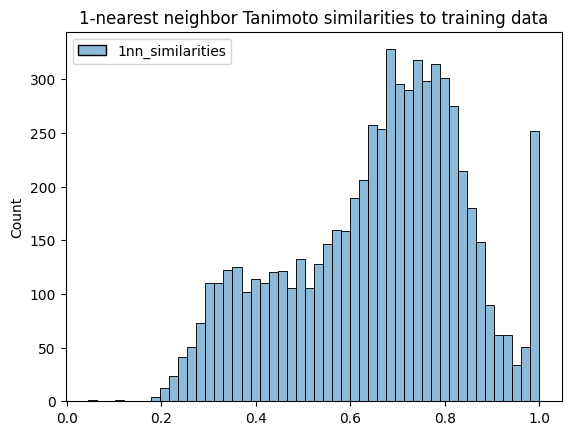

In [13]:
sns.histplot(pd.DataFrame({"1nn_similarities": similarities}), bins=50)
plt.title(f"1-nearest neighbor Tanimoto similarities to training data")

As the histogram shows, the similarity between the test and training set is relatively high with most compounds having a similarity >0.6 and even ~250 molecules with a Tanimoto score of 1. However, this is just a hypothetical example. If a real-world dataset would have such high similarities we would probably use cluster or time splits to reduce the similarity and data leakage. 

## Comparison to native RDKit Tanimoto computation

`NearestNeighborsRetrieverTanimoto` performs an exhaustive comparison to find the k-nearest neighbors. To do this, the full similarity matrix must be computed. MolPipeline's algorithm for finding these Tanimoto similarity scores differs from the approach in RDKit. In MolPipeline, we use an implementation based on sparse matrices that exploits the sparse matrix dot product algorithm from scipy. The central function is `tanimoto_similarity_sparse` which computes the full similarity matrix.

In [14]:
%%time
sim_matrix = tanimoto_similarity_sparse(fp_matrix, fp_matrix)
sim_matrix.shape

CPU times: user 19.3 s, sys: 9.39 s, total: 28.7 s
Wall time: 28.7 s


(19999, 19999)

In [15]:
sim_matrix

array([[1.        , 0.08783784, 0.05747126, ..., 0.09836066, 0.06730769,
        0.08602151],
       [0.08783784, 1.        , 0.45212766, ..., 0.05405405, 0.19760479,
        0.10465116],
       [0.05747126, 0.45212766, 1.        , ..., 0.04678363, 0.17368421,
        0.09230769],
       ...,
       [0.09836066, 0.05405405, 0.04678363, ..., 1.        , 0.07070707,
        0.10344828],
       [0.06730769, 0.19760479, 0.17368421, ..., 0.07070707, 1.        ,
        0.12903226],
       [0.08602151, 0.10465116, 0.09230769, ..., 0.10344828, 0.12903226,
        1.        ]])

To get the full similarity matrix with RDKit using `BulkTanimotoSimilarity`, we have to have the fingerprints as a different datastructure, for example as `ExplicitBitVect`.  

In [16]:
%%time
error_filter = ErrorFilter()

fingerprint_pipeline2 = Pipeline(
    [
        ("auto2mol", AutoToMol()),
        ("error_filter", error_filter),
        (
            "morgan2_2048",
            MolToMorganFP(n_bits=2048, radius=2, return_as="explicit_bit_vect"),
        ),
    ],
    n_jobs=-1,
)

fp_matrix_explicit = fingerprint_pipeline2.transform(df["smiles"])
fp_matrix_explicit[:4]

CPU times: user 1.27 s, sys: 143 ms, total: 1.42 s
Wall time: 1.73 s


Now, let's compute the full similarity matrix using RDKit's `BulkTanimotoSimilarity`

In [17]:
%%time
sim_mat_rdkit = np.full((len(fp_matrix_explicit), len(fp_matrix_explicit)), np.nan)
for i, query_fp in enumerate(fp_matrix_explicit):
    sim_mat_rdkit[i, :] = DataStructs.BulkTanimotoSimilarity(
        query_fp, fp_matrix_explicit
    )
sim_mat_rdkit.shape

CPU times: user 1min 9s, sys: 245 ms, total: 1min 10s
Wall time: 1min 10s


(19999, 19999)

In [18]:
assert np.allclose(sim_matrix, sim_mat_rdkit)

Based on this simple comparison MolPipeline's similarity matrix computation is about ~2-3 times faster than RDKit's. However, of course there are many other things to consider that are not touched in this notebook. For example, `tanimoto_similarity_sparse` uses more memory since it needs intermediate matrices while `BulkTanimotoSimilarity` uses almost no memory. In addition, for both approaches different strategies for parallelization come to mind (one is implemented in `NearestNeighborsRetrieverTanimoto`), which can be beneficial in different scenarios. Lastly, while the here discussed functions are useful for easy analysis in Python, there are highly optimized tools for similarity search, like [Artor](https://www.nextmovesoftware.com/arthor.html) which should probably be used when search speed is essential. 